In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

df = pd.read_csv('data/Huntington_2019_calibration_data.csv')


df["EcoliAve_CFU"] = np.log10(df["EcoliAve_CFU"].clip(lower=1.0))      # avoid -inf at 0
df["Lake_Turb_NTRU"] = np.log10(df["Lake_Turb_NTRU"].clip(lower=1e-6))   # avoid -inf/negatives
df["WaveHt_Ft"] = np.sqrt(np.maximum(df["WaveHt_Ft"], 0.0))         # sqrt needs >=0
df["AirportRain48W_in"] = np.sqrt(np.maximum(df["AirportRain48W_in"], 0.0))


X = df.drop(columns=['Date', 'EcoliAve_CFU'])
y = df['EcoliAve_CFU']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negative MSE
scoring = {"rmse": rmse_scorer, "r2": "r2"}

In [3]:
ridge_baseline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

# Cross-val on the TRAIN split only
cv_r2  = cross_val_score(ridge_baseline, X_train, y_train, cv=cv, scoring="r2")
cv_mse = -cross_val_score(ridge_baseline, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
cv_rmse = np.sqrt(cv_mse)

print("Baseline Ridge — CV R²:", cv_r2.mean(), "±", cv_r2.std())
print("Baseline Ridge — CV RMSE (log10):", np.sqrt(cv_mse).mean(), "±", np.sqrt(cv_mse).std())

Baseline Ridge — CV R²: 0.5390575463902809 ± 0.03990325066940467
Baseline Ridge — CV RMSE (log10): 0.44385293077533294 ± 0.021760974025344645


In [4]:
# SGD (L1/L2/ElasticNet)
pipe_sgd = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("sgd", SGDRegressor(random_state=42, max_iter=3000))
])
grid_sgd = {
    "sgd__penalty": ["l2", "l1", "elasticnet"],
    "sgd__alpha":   [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
    "sgd__l1_ratio": [0.15, 0.5, 0.9]  # only used for elasticnet
}

# Linear: Ridge
pipe_ridge = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])
grid_ridge = {"ridge__alpha": [0.03, 0.1, 0.3, 1, 3, 10, 30, 100]}

# Linear: Lasso
pipe_lasso = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("lasso", Lasso(random_state=42, max_iter=20000))  # higher max_iter for stability
])
grid_lasso = {
    "lasso__alpha": [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0]
}

# Polynomial regression: degree=2 + Ridge
pipe_poly_ridge = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ("ridge", Ridge(random_state=42))
])
grid_poly_ridge = {
    "poly__degree": [1, 2],  # 1 = baseline linear; 2 = squares + interactions
    "ridge__alpha": [0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
}

In [5]:
def run_grid(name, pipe, grid):
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=scoring, refit="r2", n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    return name, gs.best_estimator_, pd.DataFrame(gs.cv_results_)

results = []
for name, pipe, grid in [
    ("SGD", pipe_sgd, grid_sgd),
    ("Ridge", pipe_ridge, grid_ridge),
    ("Lasso", pipe_lasso, grid_lasso),
    ("PolyRidge", pipe_poly_ridge, grid_poly_ridge)
]:
    results.append(run_grid(name, pipe, grid))

# unpack
models = {name: est for (name, est, df) in results}
cv_tables = {name: df for (name, est, df) in results}

In [6]:
def summarize(name, model):
    # CV on train
    cv_r2  = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
    cv_mse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
    cv_rmse = np.sqrt(cv_mse)

    # Test (log10)
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)
    test_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    test_r2_log   = r2_score(y_test, y_pred_log)

    return {
        "model": name,
        "cv_r2_mean": float(cv_r2.mean()), "cv_r2_std": float(cv_r2.std()),
        "cv_rmse_log10_mean": float(cv_rmse.mean()), "cv_rmse_log10_std": float(cv_rmse.std()),
        "test_r2_log10": float(test_r2_log), "test_rmse_log10": float(test_rmse_log)
    }

rows = [summarize(n, m) for n, m in models.items()]
cmp = pd.DataFrame(rows).sort_values("cv_r2_mean", ascending=False)
display(cmp)

,model,cv_r2_mean,cv_r2_std,cv_rmse_log10_mean,cv_rmse_log10_std,test_r2_log10,test_rmse_log10
3,PolyRidge,0.542412,0.034827,0.442331,0.019310,0.565904,0.433675
1,Ridge,0.539137,0.039174,0.443847,0.021766,0.548071,0.442493
2,Lasso,0.539040,0.039811,0.443867,0.021820,0.547748,0.442651
0,SGD,0.538564,0.039605,0.444098,0.021494,0.548262,0.442399


In [7]:
def print_best_from_models(models):
    if "Ridge" in models:
        r = models["Ridge"].named_steps["ridge"]
        print(f"Ridge: alpha={r.alpha}")

    if "Lasso" in models:
        l = models["Lasso"].named_steps["lasso"]
        print(f"Lasso: alpha={l.alpha}")

    if "SGD" in models:
        s = models["SGD"].named_steps["sgd"]
        # l1_ratio is only relevant when penalty='elasticnet'
        print(f"SGD: penalty={s.penalty}, alpha={s.alpha}, l1_ratio={getattr(s, 'l1_ratio', None)}")

    if "PolyRidge" in models:
        pr = models["PolyRidge"]
        deg = pr.named_steps["poly"].degree
        a   = pr.named_steps["ridge"].alpha
        print(f"PolyRidge: degree={deg}, ridge__alpha={a}")

print_best_from_models(models)

Ridge: alpha=10
Lasso: alpha=0.001
SGD: penalty=elasticnet, alpha=0.001, l1_ratio=0.9
PolyRidge: degree=2, ridge__alpha=10


In [8]:
candidates = ["SGD", "Ridge", "Lasso", "PolyRidge"]

best = cmp[cmp["model"].isin(candidates)].sort_values("cv_r2_mean", ascending=False).iloc[0]["model"]
print("Best model (by CV R2):", best)

Best model (by CV R2): PolyRidge


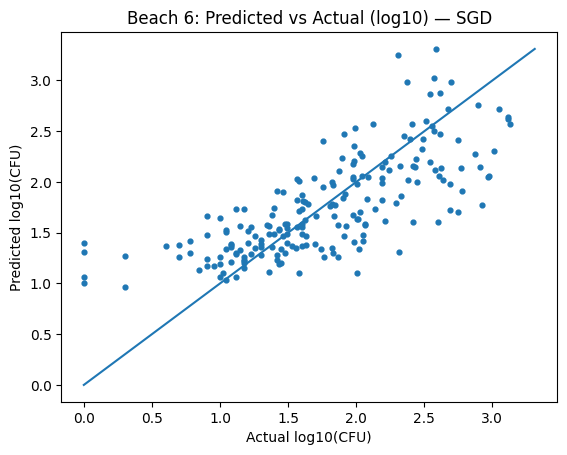

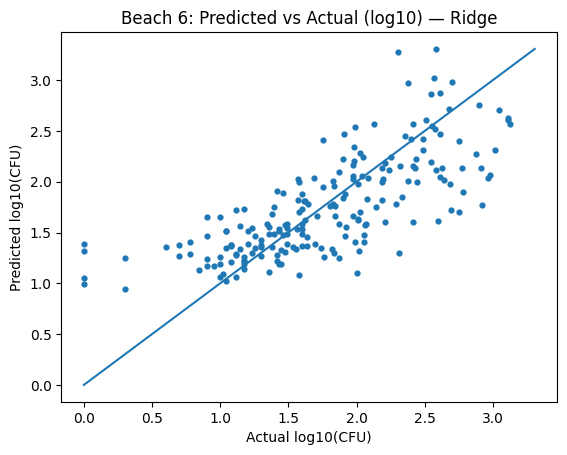

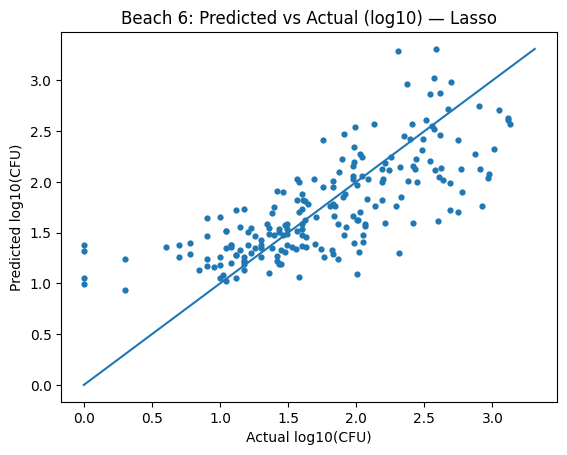

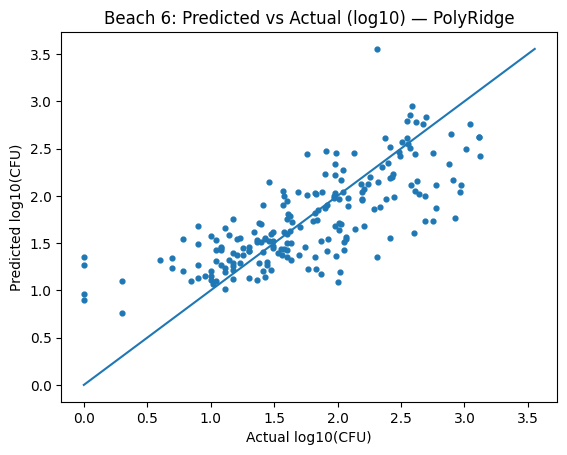

In [9]:
import matplotlib.pyplot as plt

def pred_vs_actual_plot(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    fig = plt.figure()
    plt.scatter(y_test, y_pred, s=12)
    lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.title(f"Beach 6: Predicted vs Actual (log10) — {name}")
    plt.xlabel("Actual log10(CFU)"); plt.ylabel("Predicted log10(CFU)")
    plt.show()

for name, model in models.items():
    pred_vs_actual_plot(name, model)

In [10]:
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.


In [11]:
import statsmodels.api as sm

poly_deg = 2
ridge_alpha = 10

poly = PolynomialFeatures(degree=poly_deg, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X.values)
feat_names = poly.get_feature_names_out(X.columns)
X_df = pd.DataFrame(X_poly, index=X.index, columns=feat_names)

# 2) Align X and y, drop NaNs, ensure floats
mask = pd.concat([X_df, y.rename("__y__")], axis=1).dropna().index
X_df = X_df.loc[mask].astype(float)
y_vec = y.loc[mask].astype(float)

# 3) Fit OLS with intercept on LOG10 target
Xc = sm.add_constant(X_df)
ols = sm.OLS(y_vec, Xc, missing="drop").fit()

# 4) Pretty tables (display only; no files)
param_table = pd.DataFrame({
    "Coefficient": ols.params,
    "StdError":    ols.bse,
    "tStatistic":  ols.tvalues,
    "PValue":      ols.pvalues
})
param_table.index.name = "Parameter"

rmse_log10 = float(np.sqrt(ols.mse_resid))
topline = pd.Series({
    "Winner": f"PolyRidge (degree={poly_deg}, alpha={ridge_alpha}) — OLS refit on poly terms",
    "R2": ols.rsquared,
    "Adj_R2": ols.rsquared_adj,
    "RMSE_log10": rmse_log10,
    "AIC": ols.aic,
    "BIC": ols.bic,
})

# 5) DISPLAY
print(ols.summary())
with pd.option_context("display.float_format", "{:.6g}".format):
    print("\n OLS Parameters (coef / SE / t / p)")
    display(param_table)
    print("\n Topline Metrics (log10)")
    display(topline.to_frame("value"))

                            OLS Regression Results                            
Dep. Variable:           EcoliAve_CFU   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     65.86
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          4.47e-166
Time:                        12:38:13   Log-Likelihood:                -584.39
No. Observations:                1011   AIC:                             1211.
Df Residuals:                     990   BIC:                             1314.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

,Coefficient,StdError,tStatistic,PValue
Parameter,,,,
const,-1.72485,0.659844,-2.61402,0.00908417
Lake_Temp_C,0.157727,0.0550714,2.86404,0.00427103
Lake_Turb_NTRU,1.45151,0.416025,3.48899,0.000506192
WaveHt_Ft,0.0478395,0.313127,0.15278,0.878603
LL_PreDay,0.46729,0.730412,0.639762,0.522475
AirportRain48W_in,0.897136,0.259623,3.45554,0.000572503
Lake_Temp_C^2,-0.0020296,0.00120226,-1.68814,0.0916987
Lake_Temp_C Lake_Turb_NTRU,-0.0407204,0.0155683,-2.6156,0.00904269
Lake_Temp_C WaveHt_Ft,0.0170903,0.0121962,1.40128,0.161445



 Topline Metrics (log10)


,value
Winner,"PolyRidge (degree=2, alpha=10) — OLS refit on ..."
R2,0.570925
Adj_R2,0.562257
RMSE_log10,0.43587
AIC,1210.78
BIC,1314.07


In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Get tuned PolyRidge model
poly_ridge_model = models["PolyRidge"]

# Refit on training data
poly_ridge_model.fit(X_train, y_train)

# Expand features the same way the pipeline does
poly = poly_ridge_model.named_steps["poly"]
ridge = poly_ridge_model.named_steps["ridge"]

X_poly = poly.fit_transform(X_train)
feature_names = poly.get_feature_names_out(X_train.columns)

# Build coefficient table
poly_coefs = ridge.coef_
poly_intercept = ridge.intercept_

poly_coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": poly_coefs
}).sort_values("Coefficient", key=abs, ascending=False)

print(f"Intercept: {poly_intercept:.4f}")
display(poly_coef_table)

Intercept: 1.7243


,Feature,Coefficient
1,Lake_Turb_NTRU,0.280736
4,AirportRain48W_in,0.250905
0,Lake_Temp_C,0.111629
2,WaveHt_Ft,0.093133
16,WaveHt_Ft AirportRain48W_in,-0.064355
3,LL_PreDay,0.063419
13,Lake_Turb_NTRU AirportRain48W_in,0.059347
6,Lake_Temp_C Lake_Turb_NTRU,-0.039144
9,Lake_Temp_C AirportRain48W_in,-0.031429
7,Lake_Temp_C WaveHt_Ft,0.031134


In [13]:
# Get tuned PolyRidge model
poly_ridge_model = models["PolyRidge"]
poly_ridge_model.fit(X_train, y_train)

# Access polynomial transformer and ridge regressor
poly = poly_ridge_model.named_steps["poly"]
ridge = poly_ridge_model.named_steps["ridge"]

# Predict on the test set
y_pred = poly_ridge_model.predict(X_test)

# Differences
diffs = y_pred - y_test
abs_diffs = np.abs(diffs)

# Ensure X_test goes in as a DataFrame with the same column names
X_test_poly = poly.transform(pd.DataFrame(X_test, columns=X_train.columns))
feature_names = poly.get_feature_names_out(X_train.columns)

# Wrap into DataFrame
X_test_poly_df = pd.DataFrame(X_test_poly, index=X_test.index, columns=feature_names)

# Build error DataFrame
poly_ridge_errors = X_test_poly_df.copy()
poly_ridge_errors["Actual"] = y_test
poly_ridge_errors["Predicted"] = y_pred
poly_ridge_errors["Difference"] = diffs
poly_ridge_errors["AbsDifference"] = abs_diffs

# Sort by biggest error
poly_ridge_errors_sorted = poly_ridge_errors.sort_values("AbsDifference", ascending=False)

print("Top 10 errors (PolyRidge tuned):")
display(poly_ridge_errors_sorted.head(10))

Top 10 errors (PolyRidge tuned):


/Users/bryceclement/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


,Lake_Temp_C,Lake_Turb_NTRU,WaveHt_Ft,LL_PreDay,AirportRain48W_in,Lake_Temp_C^2,Lake_Temp_C Lake_Turb_NTRU,Lake_Temp_C WaveHt_Ft,Lake_Temp_C LL_PreDay,Lake_Temp_C AirportRain48W_in,...,WaveHt_Ft^2,WaveHt_Ft LL_PreDay,WaveHt_Ft AirportRain48W_in,LL_PreDay^2,LL_PreDay AirportRain48W_in,AirportRain48W_in^2,Actual,Predicted,Difference,AbsDifference
806,15.6,0.954243,0.316228,0.060,0.244949,243.36,14.886183,4.933153,0.9360,3.821204,...,0.10,0.018974,0.077460,0.003600,0.014697,0.060,0.000000,1.352845,1.352845,1.352845
822,21.5,0.812913,0.000000,0.040,0.000000,462.25,17.477637,0.000000,0.8600,0.000000,...,0.00,0.000000,0.000000,0.001600,0.000000,0.000,0.000000,1.268564,1.268564,1.268564
394,26.1,1.895423,0.707107,0.663,1.483240,681.21,49.470528,18.455487,17.3043,38.712556,...,0.50,0.468812,1.048809,0.439569,0.983388,2.200,2.307496,3.554539,1.247043,1.247043
362,21.7,0.770852,0.707107,0.171,0.632456,470.89,16.727489,15.344217,3.7107,13.724285,...,0.50,0.120915,0.447214,0.029241,0.108150,0.400,2.923762,1.763158,-1.160604,1.160604
687,22.1,0.875061,0.316228,-0.100,0.692820,488.41,19.338854,6.988634,-2.2100,15.311329,...,0.10,-0.031623,0.219089,0.010000,-0.069282,0.480,2.748963,1.732740,-1.016223,1.016223
750,24.3,0.875061,0.000000,0.020,0.353553,590.49,21.263989,0.000000,0.4860,8.591347,...,0.00,0.000000,0.000000,0.000400,0.007071,0.125,2.600973,1.602486,-0.998487,0.998487
209,23.9,0.380211,0.282843,0.036,0.316228,571.21,9.087049,6.759941,0.8604,7.557844,...,0.08,0.010182,0.089443,0.001296,0.011384,0.100,2.311754,1.350776,-0.960978,0.960978
696,15.0,0.832509,0.000000,-0.090,0.000000,225.00,12.487634,0.000000,-1.3500,0.000000,...,0.00,-0.000000,0.000000,0.008100,-0.000000,0.000,0.000000,0.960381,0.960381,0.960381
29,24.4,0.633468,0.707107,0.050,0.632456,595.36,15.456630,17.253405,1.2200,15.431915,...,0.50,0.035355,0.447214,0.002500,0.031623,0.400,2.690196,1.731454,-0.958742,0.958742
814,18.0,1.301030,1.000000,0.170,0.600000,324.00,23.418540,18.000000,3.0600,10.800000,...,1.00,0.170000,0.600000,0.028900,0.102000,0.360,2.965202,2.035984,-0.929218,0.929218
